# Бибиков Павел ИУ5-22М РК1

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [18]:
warnings.filterwarnings('ignore') # Игнорируем предупреждения для чистоты вывода

In [19]:
# Загрузка набора данных "Титаник"
df = sns.load_dataset('titanic')

In [20]:
# Краткий обзор данных
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
df.info()
print("\nСтатистическое описание числовых признаков:")
print(df.describe())
print("\nСтатистическое описание категориальных признаков:")
print(df.describe(include=['object', 'category'])) # 'category' для Pclass и др.

Первые 5 строк данных:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------


## Задача №3: Кодирование категориального признака методом "Weight of Evidence (WoE)"
###
## Выберем категориальный признак `embarked` (порт посадки) и бинарную целевую переменную `survived`.
#
# **Шаги:**
### 1. Обработать пропуски в `embarked`.
### 2. Рассчитать количество "хороших" (survived=1) и "плохих" (survived=0) исходов для каждой категории `embarked`.
### 3. Рассчитать долю "хороших" и "плохих" исходов для каждой категории от общего числа "хороших" и "плохих" исходов соответственно.
### 4. Рассчитать WoE для каждой категории как `ln(доля хороших / доля плохих)`.
### 5. Создать новый признак `embarked_woe` с полученными значениями WoE.

In [21]:
# 1. Обработка пропусков в 'embarked'
# Найдем наиболее частый порт посадки (моду)
most_frequent_port = df['embarked'].mode()[0]
print(f"Наиболее частый порт посадки (мода): {most_frequent_port}")

Наиболее частый порт посадки (мода): S


In [22]:
df['embarked'].fillna(most_frequent_port, inplace=True)
print(f"\nПропуски в 'embarked' после заполнения: {df['embarked'].isnull().sum()}")


Пропуски в 'embarked' после заполнения: 0


In [23]:
# 2. Расчет событий для каждой категории 'embarked'
# Добавим +0.5 к каждой группе для сглаживания (избежание деления на ноль)
smooth_factor = 0.5

In [24]:
# Группируем данные по 'embarked' и считаем количество выживших (good) и погибших (bad)
woe_df = df.groupby('embarked')['survived'].agg(
    [('all', 'count'),
     ('good', lambda x: (x == 1).sum() + smooth_factor),
     ('bad', lambda x: (x == 0).sum() + smooth_factor)]
)

print("\nРасчет событий по категориям 'embarked':")
print(woe_df)


Расчет событий по категориям 'embarked':
          all   good    bad
embarked                   
C         168   93.5   75.5
Q          77   30.5   47.5
S         646  219.5  427.5


In [25]:
# 3. Расчет общих событий и долей
total_good = df['survived'].sum() + smooth_factor * df['embarked'].nunique()
total_bad = (df.shape[0] - df['survived'].sum()) + smooth_factor * df['embarked'].nunique()

woe_df['distr_good'] = woe_df['good'] / total_good
woe_df['distr_bad'] = woe_df['bad'] / total_bad

print("\nРасчет долей:")
print(woe_df)


Расчет долей:
          all   good    bad  distr_good  distr_bad
embarked                                          
C         168   93.5   75.5    0.272198   0.137148
Q          77   30.5   47.5    0.088792   0.086285
S         646  219.5  427.5    0.639010   0.776567


In [26]:
# 4. Расчет WoE
woe_df['woe'] = np.log(woe_df['distr_good'] / woe_df['distr_bad'])

print("\nРасчет WoE:")
print(woe_df)


Расчет WoE:
          all   good    bad  distr_good  distr_bad       woe
embarked                                                    
C         168   93.5   75.5    0.272198   0.137148  0.685469
Q          77   30.5   47.5    0.088792   0.086285  0.028637
S         646  219.5  427.5    0.639010   0.776567 -0.194962


In [27]:
# 5. Создание нового признака и применение WoE
# Создаем словарь для маппинга
woe_map = woe_df['woe'].to_dict()
print(f"\nСловарь для WoE маппинга: {woe_map}")


Словарь для WoE маппинга: {'C': 0.6854686245399929, 'Q': 0.028636817073100906, 'S': -0.19496221136125838}


In [28]:
# Применяем маппинг к исходному датафрейму
df['embarked_woe'] = df['embarked'].map(woe_map)

print("\nПервые 5 строк данных с новым признаком 'embarked_woe':")
print(df[['embarked', 'embarked_woe', 'survived']].head())
print("\nПроверка типов данных после добавления WoE:")
df.info()


Первые 5 строк данных с новым признаком 'embarked_woe':
  embarked  embarked_woe  survived
0        S     -0.194962         0
1        C      0.685469         1
2        S     -0.194962         1
3        S     -0.194962         1
4        S     -0.194962         0

Проверка типов данных после добавления WoE:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   survived      891 non-null    int64   
 1   pclass        891 non-null    int64   
 2   sex           891 non-null    object  
 3   age           714 non-null    float64 
 4   sibsp         891 non-null    int64   
 5   parch         891 non-null    int64   
 6   fare          891 non-null    float64 
 7   embarked      891 non-null    object  
 8   class         891 non-null    category
 9   who           891 non-null    object  
 10  adult_male    891 non-null    bool    
 11  deck  

## Задача №23: Обнаружение и удаление выбросов на основе правила трех сигм
#
## Выберем числовой признак `fare` (стоимость билета).
#
## **Шаги:**
### 1. Рассчитать среднее значение (`mean`) и стандартное отклонение (`std`) для признака `fare`.
### 2. Определить нижнюю и верхнюю границы по правилу трех сигм: `mean ± 3 * std`.
### 3. Найти наблюдения, выходящие за эти границы.
### 4. Создать новый датафрейм, исключив найденные выбросы.

In [29]:
# 1. Расчет среднего и стандартного отклонения для 'fare'
feature_name = 'fare'
mean_val = df[feature_name].mean()
std_val = df[feature_name].std()

print(f"Признак: {feature_name}")
print(f"Среднее значение: {mean_val:.2f}")
print(f"Стандартное отклонение: {std_val:.2f}")

Признак: fare
Среднее значение: 32.20
Стандартное отклонение: 49.69


In [30]:
# 2. Определение границ по правилу трех сигм
lower_bound = mean_val - 3 * std_val
upper_bound = mean_val + 3 * std_val

print(f"Нижняя граница (3 сигмы): {lower_bound:.2f}")
print(f"Верхняя граница (3 сигмы): {upper_bound:.2f}")

Нижняя граница (3 сигмы): -116.88
Верхняя граница (3 сигмы): 181.28


In [31]:
# 3. Нахождение выбросов
outliers = df[(df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)]
print(f"\nНайдено выбросов в признаке '{feature_name}': {len(outliers)}")
if len(outliers) > 0:
    print("Примеры выбросов:")
    print(outliers[[feature_name]].head())



Найдено выбросов в признаке 'fare': 20
Примеры выбросов:
         fare
27   263.0000
88   263.0000
118  247.5208
258  512.3292
299  247.5208


In [32]:
# 4. Удаление выбросов (создание нового датафрейма без них)
df_cleaned = df[(df[feature_name] >= lower_bound) & (df[feature_name] <= upper_bound)]

print(f"\nРазмер исходного датафрейма: {df.shape}")
print(f"Размер датафрейма после удаления выбросов по '{feature_name}': {df_cleaned.shape}")
print(f"Удалено строк: {df.shape[0] - df_cleaned.shape[0]}")


Размер исходного датафрейма: (891, 16)
Размер датафрейма после удаления выбросов по 'fare': (871, 16)
Удалено строк: 20


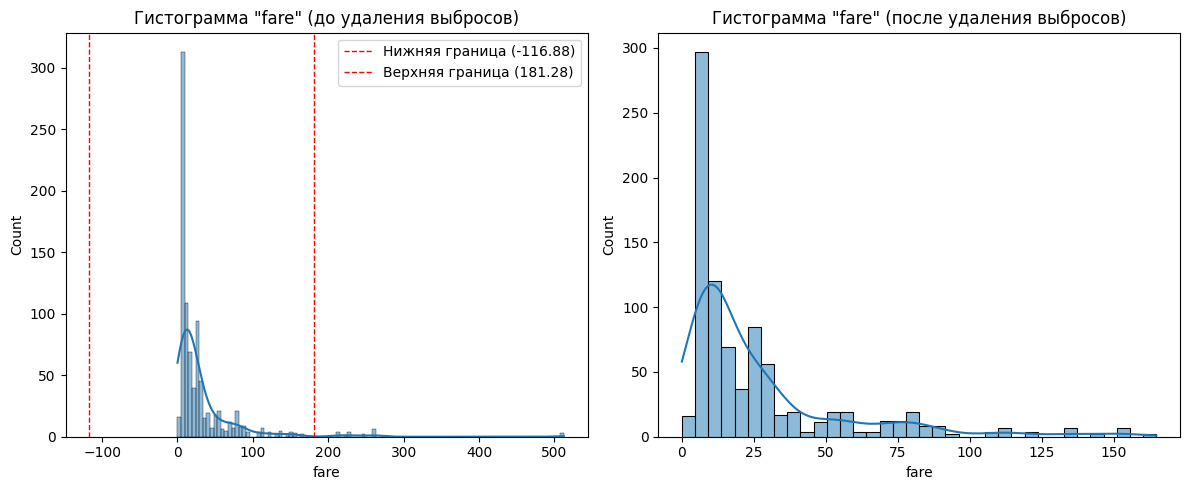

In [33]:
# Визуализация для сравнения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[feature_name], kde=True)
plt.title(f'Гистограмма "{feature_name}" (до удаления выбросов)')
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=1, label=f'Нижняя граница ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=1, label=f'Верхняя граница ({upper_bound:.2f})')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned[feature_name], kde=True)
plt.title(f'Гистограмма "{feature_name}" (после удаления выбросов)')

plt.tight_layout()
plt.show()

### ## Дополнительное требование: Построение гистограммы
#
### Построим гистограмму для признака `age` (возраст). Предварительно обработаем пропуски, заполнив их медианным значением.

In [34]:
# Выбор признака для гистограммы
hist_feature = 'age'

In [35]:
# Обработка пропусков в 'age' (заполнение медианой)
median_age = df[hist_feature].median()
print(f"Медианный возраст: {median_age:.2f}")
df[hist_feature].fillna(median_age, inplace=True)
print(f"Пропуски в '{hist_feature}' после заполнения: {df[hist_feature].isnull().sum()}")

Медианный возраст: 28.00
Пропуски в 'age' после заполнения: 0


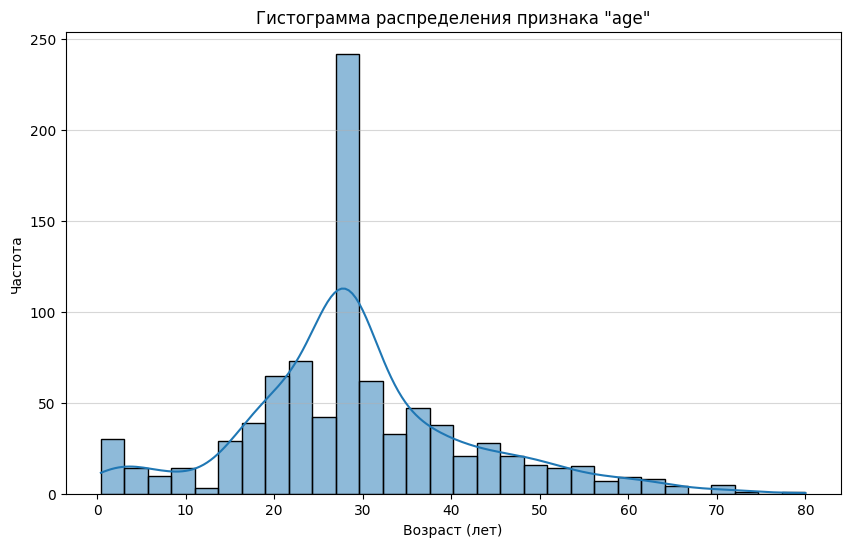

In [36]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(df[hist_feature], bins=30, kde=True) # kde=True добавляет сглаженную кривую плотности
plt.title(f'Гистограмма распределения признака "{hist_feature}"')
plt.xlabel('Возраст (лет)')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()